## Header Code

In [6]:
%matplotlib inline
import numpy as np
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels import discrete

import re
import pandas as pd
import math 
import csv
import time
import dateutil
from datetime import datetime
import seaborn as sns

from IPython.core.display import HTML
HTML("<style>.container {width:50% !important; }</style>");

In [7]:
# pandas options plus some more
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
pd.options.display.float_format = '{:,.2f}'.format
sns.set_style("whitegrid")
sns.set_context("poster")

In [8]:
# Matplotlib Formatting
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import ticker


millnames = ['',' Thousand',' Million',' Billion',' Trillion']
def millify(n, pos):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))
    thingtoreturn = n / 10**(3 * millidx)
    if thingtoreturn % 1 == 0:
        return '{:.0f}{}'.format(thingtoreturn, millnames[millidx])
    elif thingtoreturn % 0.1 == 0:
        return '{:.1f}{}'.format(thingtoreturn, millnames[millidx])
    else:
        return '{:.2f}{}'.format(thingtoreturn, millnames[millidx])

## Pre-load

**Municipal Codes**

In [9]:
municipal_codes_df = pd.read_excel("./exports/Municipal Code Matching.xlsx")

In [10]:
municipal_codes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 3 columns):
mun_id      174 non-null int64
mun         174 non-null object
mun_type    174 non-null object
dtypes: int64(1), object(2)
memory usage: 4.1+ KB


**Spending Economic Classes** 

In [11]:
econ_breakdown = pd.read_csv("./Budgets/econ_breakdown.csv")

In [12]:
econ_breakdown.columns

Index([u'ec_div_id', u'ec_div_name_english', u'ec_group_id', u'ec_group_name_english', u'ec_class_id', u'ec_class_name_english'], dtype='object')

In [13]:
for col in [u'ec_div_id', u'ec_group_id', u'ec_class_id']:
    econ_breakdown[col] = econ_breakdown[col].fillna(-1).astype(int)

**Spending Functional Classes**

In [14]:
func_breakdown = pd.read_csv("./Budgets/func_breakdown.csv")

C:\Users\nolefp\AppData\Roaming\Python\Python27\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (1,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
func_breakdown.columns

Index([u'func_div_id', u'func_div_name_english', u'func_group_id', u'func_group_name_english', u'func_class_id', u'func_class_name_english'], dtype='object')

In [16]:
for col in [u'func_div_id', u'func_group_id', u'func_class_id']:
    func_breakdown[col] = func_breakdown[col].fillna(-1).astype(int)

**Income Classification**

In [17]:
income_breakdown = pd.read_csv("./Budgets/income_breakdown.csv")

In [18]:
income_breakdown.columns

Index([u'l2', u'l2_name', u'l2_name_english', u'l3', u'l3_name', u'l3_name_english', u'l4', u'l4_name', u'l4_name_english', u'l6', u'l6_name', u'l6_name_english'], dtype='object')

In [19]:
codes_income =          [u'l2', u'l3', u'l4', u'l6']
names_income =          [u'l2_name', u'l3_name', u'l4_name', u'l6_name']
names_english_income =  [u'l2_name_english', u'l3_name_english', u'l4_name_english', u'l6_name_english']

for col in codes_income:
    income_breakdown[col] = income_breakdown[col].fillna(-1).astype(int)

** load necessary datasets **

In [20]:
# incomes
incomesdf = pd.read_csv("./exports/incomesdf.csv")

# apanel data
apaneldf = pd.read_csv("./exports/apaneldf.csv")

# convert date to years in int
apaneldf.date = apaneldf.date.str.replace("-\d\d-\d\d","").astype(int)

# HYPOTHESES

## Transfers

### Change Over Time

** Calculate Share Changes **

In [58]:
# get total transfers by year
transfers = incomesdf[incomesdf.l6_name_english == 'Transfers from other level of government'].copy()
transfers_munyeardf = transfers.groupby(["mun_id","year"]).sum().drop(["l2","l4","l3","l6","Unnamed: 0"], axis=1).unstack(level=1)
transfers_munyeardf.columns = ['_'.join(("transfers",str(col[1]))).strip() for col in transfers_munyeardf.columns.values]

#normalize
norm_transfers_munyeardf = pd.DataFrame()

for col in transfers_munyeardf.columns:
    norm_transfers_munyeardf[col] = (transfers_munyeardf[col] / transfers_munyeardf[col].sum()).copy()

def change(df):
    x11 = df['transfers_2012'] == 0
    x13 = df['transfers_2013'] == 0
    if x11 & x13:
        return 0    
    if  ~x11 & x13:
        return -1
    if x11 &  ~x13:
        return np.nan
    else:
        return ((df['transfers_2013'] - df['transfers_2012'])/df['transfers_2012']).copy()

#find 2011, 2013 difference
share_change = pd.DataFrame()
share_change["norm_percent_change"] = norm_transfers_munyeardf.apply(change, axis=1) * 100

** Alignment Changes **

In [59]:
def gov_change(df):
    if np.isnan(df["ingov11"])  | np.isnan(df["ingov13"]):
        return np.nan
    
    if (df["ingov11"] != 1) & (df["ingov13"] != 1):
        return "3unaligned both years"
    
    if (df["ingov11"] == 1) & (df["ingov13"] == 1):
        return "2aligned both years"
    
    if (df["ingov11"] != 1) & (df["ingov13"] == 1):
        return "1became aligned"
    
    if (df["ingov11"] == 1) & (df["ingov13"] != 1):
        return "4stopped being aligned"
    
share_change["ingov11"] = apaneldf[apaneldf.date == 2011].set_index("mun_id").in_gov11.copy()
share_change["ingov13"] = apaneldf[apaneldf.date == 2013].set_index("mun_id").ingov12.copy()

share_change["gov_change"] = share_change.apply(gov_change, axis=1)

share_change["mun"] = municipal_codes_df.set_index("mun_id").mun
share_change.sort_values("norm_percent_change", ascending=0, inplace=1)


In [60]:
share_change.gov_change = share_change.gov_change.astype("category")
share_change.gov_change.unique().reorder_categories(["1became aligned","2aligned both years",
                                                     "3unaligned both years","4stopped being aligned"], ordered=True)


share_change.to_csv("./exports/2011_to_2013.csv")

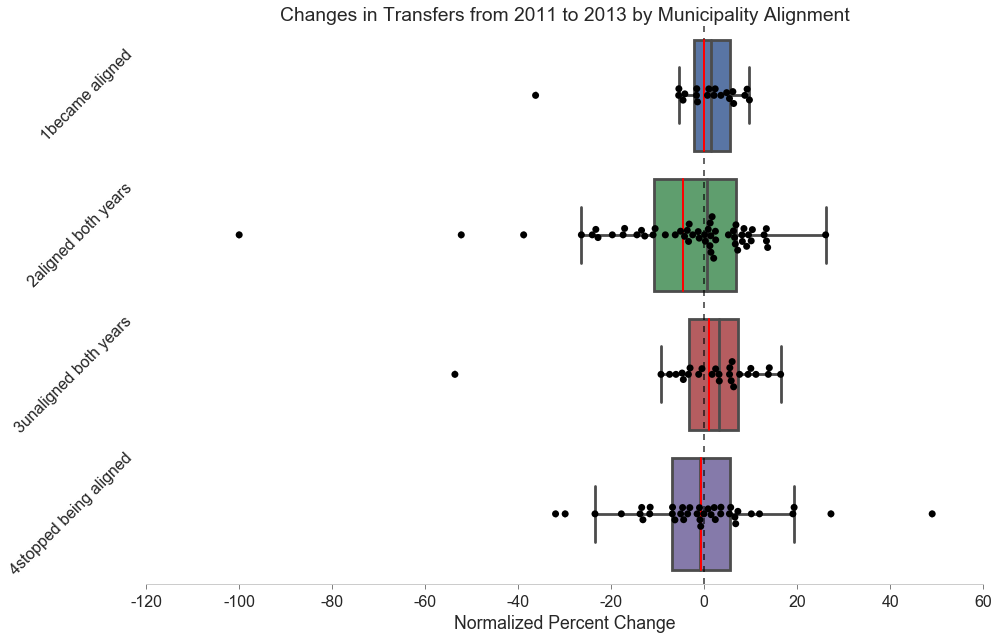

In [61]:
fig, ax = plt.subplots(figsize=(15,10))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(millify))

# rotate x labels
locs, labels = plt.yticks()
plt.setp(labels, rotation=45);
plt.grid()

plt.axvline(0,color='black',alpha=.6,ls='dashed',lw=2)
sns.swarmplot("norm_percent_change", "gov_change" ,data=share_change.dropna(), color='black', size=7)
sns.boxplot("norm_percent_change", "gov_change" ,data=share_change.dropna(),
            meanprops={'linewidth':2, 'color':'red'}, meanline=1, showmeans=1)

title = "Changes in Transfers from 2011 to 2013 by Municipality Alignment"
subtitle = "Depending on alignment with national coalition pre and after 2012 election"
plt.title(title)

# axes options
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='x',which='major', direction='out', width=1,length=5,bottom='on',top="off",color='grey')

ax.set_ylabel("")

ax.set_xlabel("Normalized Percent Change")

plt.savefig("./exports/figures" + title, bbox_inches='tight')

#  Regression

In [ ]:
alignmentdf = pd.get_dummies(share_change.dropna(), prefix="dummy", columns=["gov_change"])
alignmentdf["constant"] = 1

In [ ]:
mod = sm.OLS(alignmentdf.ix[:,0],alignmentdf.ix[:,-5:])
res = mod.fit()
print res.summary()

In [ ]:
share_change.to_csv("./exports/changesdf.csv")

## Time slice Comparisons